In [1]:
#load benchmarks problems

import numpy as np

eqc = np.load('eqcS.npy',allow_pickle=True).item() 
class prb:   #this will be your black box function
    def __init__(self,prob,noisy_level):
        # function for generating data
        self.func=prob['func']
        # number of constraints
        self.n_con=prob['n_con']
        # noise level
        self.nl=noisy_level
        # constraints
        self.con=[]
        for i in range(self.n_con):
            self.con.append(prob['con'+str(i+1)])
    def datcol(self,x):
        try:
            # eval takes string type input and evaluates python code. Input can be
            #a mathematical function or a python function which will be called.
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)
    def constraint(self,x):
        # Appears to evaluate if the constraints are satisfied
        #returns 1 if all constraints are satisfied, else -1
        try:     
            m,n=np.shape(x)
        except:
            x = np.array([x])
            m,n=np.shape(x)
        y=np.empty((self.n_con))
        for i in range(self.n_con):
            y[i]=eval(self.con[i])     
        if y.all() == 1.:
            label = 1.
        else:
            label = -1.
        return label
    
bcp=np.load('bcp8.npy',allow_pickle=True).item()

class benchmark:
    def __init__(self,func,noisy_level):
        self.func = str(func)
        self.nl = noisy_level
    def datcol(self,x):
        try:
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)

# Helper functions from Lucas

In [2]:
# Find and replace function for editing function strings
def multiple_replace(_string:str, find_replace:list):
    new_string = _string
    for find,replace in find_replace:
        new_string = new_string.replace(find,replace)
    return new_string

# Create usable form of the function to pass to optimizers
def get_usable_fxn(dimension: int, fxn_form: str):
    find_rep_list = [('x[:,{}]'.format(dimension-1-i),'x["{}"]'.format(dimension-1-i)) for i in range(dimension)]
    opt_form = multiple_replace(fxn_form, find_rep_list)
    return opt_form

# Create search space
def create_search_space(dimension: int, xlb: list, xub: list, resolution: int = 100):
    search_space = {str(i):np.linspace(xlb[i],xub[i],resolution) for i in range(dimension)}
    return search_space

# Create a container for objective function - need to use eval to evaluate string version of function, but can't pass that
#directly to optimizer - there is probably a better way to do this, possibly using wrappers. Not worth time right now.
def create_parent_fxn(search_space,opt_form):
    search_space = search_space
    opt_form = opt_form
    def objective_fxn(search_space):
        #clear_output(wait=True)
        x = search_space
        return -1*eval(opt_form)
    return objective_fxn

# Additional Helper Functions

In [3]:
def get_valid_problems(names):
    """ 
    Some provided solutions may be invalid. This function returns valid/invalid solutions
    """

    valid_problems = []
    invalid_problems = []
    for name in names: 
        dims = bcp[f'{name}']['n']
        try:
            assert len(bcp[f'{name}']['xub']) == dims and len(bcp[f'{name}']['xlb']) == dims
            assert len(bcp[f'{name}']['xopt']) == dims 
            valid_problems.append(name)
        except:
            invalid_problems.append(name)
            continue

    print(f"There are {len(valid_problems)} valid problems and {len(invalid_problems)} invalid problems")
    
    return valid_problems, invalid_problems

def get_perturbed_solutions(test_fxn):

    """
    Returns perturbed optimal solutions for a given input problem 
    """

    dims = test_fxn['n']
    perturbed_solutions = []

    for dim in range(dims):
        opt = test_fxn['xopt'][dim]       
        perturbation = np.random.uniform(-5, 5) / 100
        if opt != 0.0: perturbed_solution = np.array([opt + opt*perturbation])
        else: perturbed_solution = np.array([perturbation])
        perturbed_solutions.append(perturbed_solution)

    return np.concatenate(perturbed_solutions)

def get_all_initial_guesses(names):

    """
    Returns perturbed initial guesses for all valid problems as a list of dicts
    """

    valid_problems, invalid_problems = get_valid_problems(names)
    all_initial_guesses = []

    for problem in valid_problems:
        test_fxn = bcp[f'{problem}']
        dims = test_fxn['n']
        perturbed_solution = get_perturbed_solutions(test_fxn).astype(float)
        optimal_solution = test_fxn['xopt'].astype(float)
        percent_diff = np.divide(abs(perturbed_solution - optimal_solution), abs(optimal_solution), 
                                out=np.zeros_like(optimal_solution), where=optimal_solution!=0) * 100.0
        assert max(percent_diff) <= 5 # we sampled perturbations from uniform(-5,5)
        assert len(perturbed_solution) == dims

        initial_guess = {str(i):perturbed_solution[i] for i in range(dims)}
        all_initial_guesses.append(initial_guess)

    return all_initial_guesses, valid_problems, invalid_problems


def get_solutions(problems, solvers, all_initial_guesses):

    names = list(bcp.keys())
    final_solns = {}

    for problem in problems:

        test_fxn = bcp[f'{problem}']
        fxn_form = test_fxn['func']
        xlb = test_fxn['xlb']
        xub = test_fxn['xub']
        ndim = test_fxn['n']

        opt_form = get_usable_fxn(ndim, fxn_form)
        search_space = create_search_space(ndim, xlb, xub, resolution=100)
        fxn = create_parent_fxn(search_space,opt_form)

        initial_guess = all_initial_guesses[names.index(f'{problem}')]
        initialize={"warm_start":[initial_guess]}

        optimum = {}
        for f in solvers:
            opt = f(search_space) # initialize optimizer
            opt.search(fxn, n_iter=2500) # run optimizer
            #opt.search_data.to_csv('./{}.txt'.format(f.__name__), sep='\t', index=False)
            #optimum[f.__name__] = (-1*opt.best_score, opt.best_para)
            optimum[f.__name__] = opt.best_para

        opts = ['Solver\tOptimum']
        for i in optimum.keys():
            tmp_opt = optimum[i]
            opts += ['{}\t{}'.format(i,tmp_opt)]
        with open(f'{problem}-refinement.txt', 'w') as f:
            print('\n'.join(opts),file=f)

        final_solns[f'{problem}'] = optimum

    return final_solns


def get_solver_names(solvers):

    """ 
    Function to process strings of solvers
    """

    solver_names = []
    for i in range(len(solvers)):
        solver_name = str(solvers[i])
        # All solver names are after 4th "." 
        idx = solver_name.find(".", solver_name.find(".", solver_name.find(".", solver_name.find(".") + 1) + 1) + 1)

        # Select the substring after the 4th dot
        solver_name = solver_name[idx+1:]
        solver_name = solver_name.replace("'", "")
        solver_name = solver_name.replace(">", "")
        solver_names.append(solver_name)
    
    return solver_names

def get_maes(problems, solver_names, solver_solutions):

    """
    Get MAEs for a list of specified problems, ground truth solutions, and solution obtained
    by a list of solvers
    """
    from sklearn.metrics import mean_absolute_error

    maes = {}

    for solver_name in solver_names:
        solver_opts = [v[f'{solver_name}'] for v in solver_solutions.values()]
        true_opts = [bcp[f'{problem}']['yopt'] for problem in problems]
        mae = mean_absolute_error(solver_opts, true_opts)
        maes[f'{solver_name}'] = mae

    return maes

def create_function(problem_idx, func_string, valid_problems, invalid_problems):
    """
    This could be a duplicate of Lucas' function? Doesn't seem like it but TOCHECK
    """
    filtered_bcp = {key: value for key, value in bcp.items() if not any(s in key for s in invalid_problems)}

    for i in range(len(filtered_bcp[valid_problems[problem_idx]]['xopt'])):
        func_string = func_string.replace(f"x[:,{i}]",f"x[{str(i)}]")

    function_def = "def problem_function(x):\n    return " + func_string
    exec(function_def, globals())

    return globals()['problem_function']

def get_x_values(initial_guesses):
    x = []
    for value in initial_guesses.values():
        x.append(value)
    return x

def evaluate_refinement(problems, solver_names, all_initial_guesses, solver_solutions, valid_problems, invalid_problems, taus):

    filtered_bcp = {key: value for key, value in bcp.items() if not any(s in key for s in invalid_problems)}

    for problem in problems:
        for solver in solver_names:          
            func_string = filtered_bcp[problem]['func'] 
            problem_idx = list(filtered_bcp.keys()).index(problem)
            initial_guesses = all_initial_guesses[problem_idx]
            initial_guesses  = get_x_values(initial_guesses)
            problem_function = create_function(problem_idx, func_string, valid_problems, invalid_problems)
            f_x0 = problem_function(initial_guesses)
            solver_output = solver_solutions[problem][solver]
            solver_output  = get_x_values(solver_output)
            f_solver = problem_function(solver_output)
            f_L = filtered_bcp[problem]['yopt']

            success = []

            for j in range(len(taus)):
                try:
                    assert f_x0 - f_solver >= (1 - taus[j])*(f_x0 - f_L)
                    success.append("successful")
                except:
                    success.append("not successful")
                    pass

            solver_solutions[problem][solver] = success
    
    return solver_solutions

def get_plot_dict(problems, solver_solutions, solver_names, taus):
    # New dictionary more intuitive in ordering 
    # Note to self: This is ugly ugly ugly code
    solver_solutions_inverted = {}

    for outer_key, inner_dict in solver_solutions.items():
        for inner_key, value in inner_dict.items():
            if inner_key not in solver_solutions_inverted:
                solver_solutions_inverted[inner_key] = {}
            solver_solutions_inverted[inner_key][outer_key] = value

    solver_solutions = solver_solutions_inverted 
    plot_dict = {}

    for solver in solver_names:
        num_successfuls = [0] * len(taus)
        for inner_list in solver_solutions[solver].values():
            for i, value in enumerate(inner_list):
                if value == 'successful':
                    num_successfuls[i] += 1

        fraction = [x / len(problems) for x in num_successfuls]
        plot_dict[solver] = fraction

    return plot_dict

# Refinement Ability (Objective 3)

Note: There are several changes that could be made to improve elegance and modularity. But with deadline approaching I'd just leave it as it is. I believe there are also some irregularities in the data files in terms of the initial guesses since my code works perfectly fine for a subset of problems and gives issues for others. 

In [4]:
from gradient_free_optimizers import EnsembleOptimizer
from gradient_free_optimizers import RandomSearchOptimizer,RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer
from gradient_free_optimizers import HillClimbingOptimizer,StochasticHillClimbingOptimizer,RepulsingHillClimbingOptimizer,SimulatedAnnealingOptimizer,DownhillSimplexOptimizer
from gradient_free_optimizers import ParallelTemperingOptimizer,ParticleSwarmOptimizer,EvolutionStrategyOptimizer,SpiralOptimization
from gradient_free_optimizers import ForestOptimizer,BayesianOptimizer,TreeStructuredParzenEstimators,LipschitzOptimizer,DirectAlgorithm

names = list(bcp.keys())
all_initial_guesses, valid_problems, invalid_problems = get_all_initial_guesses(names)
# These problems don't give any issues (and potentially a few others)
problems = ['BeckerLago', 'AluffiPentini', 'trigobj', 'concha10', 'Hosaki', 'cube', 'denschnc', 'draperg', 'ex8_1_5', 'fermat_vareps',
            'Hartman3', 'hatfldb']
solvers = [RandomRestartHillClimbingOptimizer,RandomAnnealingOptimizer,PatternSearch,PowellsMethod,GridSearchOptimizer,
           DirectAlgorithm, ParticleSwarmOptimizer, EvolutionStrategyOptimizer, SimulatedAnnealingOptimizer, StochasticHillClimbingOptimizer]
solver_names = get_solver_names(solvers)
solver_solutions = get_solutions(problems, solvers, all_initial_guesses)
taus = [1e-1, 1e-2, 1e-4, 1e-6, 0e+0]
solver_refinement = evaluate_refinement(problems, solver_names, all_initial_guesses, solver_solutions, valid_problems, invalid_problems, taus)
plot_dict = get_plot_dict(problems, solver_refinement, solver_names, taus)

There are 263 valid problems and 2 invalid problems



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 5.005050505050505  
 
   Random seed: 2029456263  
 
   Evaluation time   : 0.052764892578125 sec    [32.45 %]
   Optimization time : 0.10984110832214355 sec    [67.55 %]
   Iteration time    : 0.16260600090026855 sec    [15374.59 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 5.005050505050505  
 
   Random seed: 1951232841  
 
   Evaluation time   : 0.03982353210449219 sec    [20.6 %]
   Optimization time : 0.1534886360168457 sec    [79.4 %]
   Iteration time    : 0.1933121681213379 sec    [12932.45 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 4.994949494949495  
 
   Random seed: 1200458361  
 
   Evaluation time   : 0.037615060806274414 sec    [8.89 %]
   Optimization time : 0.3856194019317627 sec    [91.11 %]
   Iteration time    : 0.4232344627380371 sec    [5906.89 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 4.994949494949495  
 
   Random seed: 1358796644  
 
   Evaluation time   : 0.05424928665161133 sec    [20.18 %]
   Optimization time : 0.21464300155639648 sec    [79.82 %]
   Iteration time    : 0.2688922882080078 sec    [9297.4 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 5.005050505050505  
 
   Random seed: 1269356974  
 
   Evaluation time   : 0.1240549087524414 sec    [52.9 %]
   Optimization time : 0.1104586124420166 sec    [47.1 %]
   Iteration time    : 0.234513521194458 sec    [10660.37 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 5.005050505050505  
 
   Random seed: 1514410588  
 
   Evaluation time   : 0.09328293800354004 sec    [24.75 %]
   Optimization time : 0.28359460830688477 sec    [75.25 %]
   Iteration time    : 0.3768775463104248 sec    [6633.45 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 4.994949494949495  
      '1' : 4.994949494949495  
 
   Random seed: 648753659  
 
   Evaluation time   : 0.041367292404174805 sec    [27.54 %]
   Optimization time : 0.10886216163635254 sec    [72.46 %]
   Iteration time    : 0.15022945404052734 sec    [16641.21 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 5.005050505050505  
 
   Random seed: 1942653766  
 
   Evaluation time   : 0.04996681213378906 sec    [24.21 %]
   Optimization time : 0.1564478874206543 sec    [75.79 %]
   Iteration time    : 0.20641469955444336 sec    [12111.54 iter/sec]
 


  2%|▏         | 40/2500 [00:00<00:00, 4064.15it/s, best_iter=40, best_pos=[50 49], best_score=-5.1015202530356945e-05]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 4.994949494949495  
 
   Random seed: 1411000667  
 
   Evaluation time   : 0.04546999931335449 sec    [25.99 %]
   Optimization time : 0.1294553279876709 sec    [74.01 %]
   Iteration time    : 0.1749253273010254 sec    [14291.81 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -5.1015202530356945e-05  
   Best parameter:
      '0' : 5.005050505050505  
      '1' : 5.005050505050505  
 
   Random seed: 643208126  
 
   Evaluation time   : 0.04602217674255371 sec    [27.01 %]
   Optimization time : 0.12438058853149414 sec    [72.99 %]
   Iteration time    : 0.17040276527404785 sec    [14671.12 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 900512999  
 
   Evaluation time   : 0.04864811897277832 sec    [28.85 %]
   Optimization time : 0.11996197700500488 sec    [71.15 %]
   Iteration time    : 0.1686100959777832 sec    [14827.11 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : 0.011111111111111072  
 
   Random seed: 689076335  
 
   Evaluation time   : 0.03836321830749512 sec    [25.06 %]
   Optimization time : 0.1147468090057373 sec    [74.94 %]
   Iteration time    : 0.15311002731323242 sec    [16328.13 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : 0.011111111111111072  
 
   Random seed: 1277356754  
 
   Evaluation time   : 0.03644371032714844 sec    [9.23 %]
   Optimization time : 0.35847949981689453 sec    [90.77 %]
   Iteration time    : 0.39492321014404297 sec    [6330.34 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 2021573051  
 
   Evaluation time   : 0.045011281967163086 sec    [17.34 %]
   Optimization time : 0.21459555625915527 sec    [82.66 %]
   Iteration time    : 0.25960683822631836 sec    [9629.95 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 1917141725  
 
   Evaluation time   : 0.08804011344909668 sec    [44.23 %]
   Optimization time : 0.11101698875427246 sec    [55.77 %]
   Iteration time    : 0.19905710220336914 sec    [12559.21 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : 0.011111111111111072  
 
   Random seed: 97092446  
 
   Evaluation time   : 0.06947946548461914 sec    [19.77 %]
   Optimization time : 0.2819547653198242 sec    [80.23 %]
   Iteration time    : 0.35143423080444336 sec    [7113.71 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35174924280463005  
   Best parameter:
      '0' : -1.0688828461211213  
      '1' : 0.011111111111111072  
 
   Random seed: 823674919  
 
   Evaluation time   : 0.04083847999572754 sec    [27.32 %]
   Optimization time : 0.10862302780151367 sec    [72.68 %]
   Iteration time    : 0.1494615077972412 sec    [16726.71 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : -0.011111111111111072  
 
   Random seed: 679127601  
 
   Evaluation time   : 0.04612112045288086 sec    [23.44 %]
   Optimization time : 0.1506788730621338 sec    [76.56 %]
   Iteration time    : 0.19679999351501465 sec    [12703.25 iter/sec]
 


  5%|▍         | 123/2500 [00:00<00:00, 5961.88it/s, best_iter=123, best_pos=[50 50], best_score=0.35232306866772606]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : 0.011111111111111072  
 
   Random seed: 2048225546  
 
   Evaluation time   : 0.06513738632202148 sec    [33.75 %]
   Optimization time : 0.1278374195098877 sec    [66.25 %]
   Iteration time    : 0.19297480583190918 sec    [12955.06 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.35232306866772606  
   Best parameter:
      '0' : -1.0456232787475657  
      '1' : 0.011111111111111072  
 
   Random seed: 958766278  
 
   Evaluation time   : 0.04579448699951172 sec    [25.52 %]
   Optimization time : 0.1336374282836914 sec    [74.48 %]
   Iteration time    : 0.17943191528320312 sec    [13932.86 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 1549207182  
 
   Evaluation time   : 0.028477907180786133 sec    [22.17 %]
   Optimization time : 0.09999251365661621 sec    [77.83 %]
   Iteration time    : 0.12847042083740234 sec    [19459.73 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.418901120478621  
   Best parameter:
      '0' : -0.6565656565656566  
 
   Random seed: 1939351659  
 
   Evaluation time   : 0.02632904052734375 sec    [20.32 %]
   Optimization time : 0.10324954986572266 sec    [79.68 %]
   Iteration time    : 0.1295785903930664 sec    [19293.31 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.418901120478621  
   Best parameter:
      '0' : -0.6565656565656566  
 
   Random seed: 1034234088  
 
   Evaluation time   : 0.02685713768005371 sec    [13.13 %]
   Optimization time : 0.17772150039672852 sec    [86.87 %]
   Iteration time    : 0.20457863807678223 sec    [12220.24 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 1325067758  
 
   Evaluation time   : 0.02874302864074707 sec    [12.53 %]
   Optimization time : 0.20061230659484863 sec    [87.47 %]
   Iteration time    : 0.2293553352355957 sec    [10900.12 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 986703635  
 
   Evaluation time   : 0.028004884719848633 sec    [27.44 %]
   Optimization time : 0.07403898239135742 sec    [72.56 %]
   Iteration time    : 0.10204386711120605 sec    [24499.27 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.418901120478621  
   Best parameter:
      '0' : -0.6565656565656566  
 
   Random seed: 1058746073  
 
   Evaluation time   : 0.02873826026916504 sec    [21.81 %]
   Optimization time : 0.10303950309753418 sec    [78.19 %]
   Iteration time    : 0.13177776336669922 sec    [18971.33 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 542492587  
 
   Evaluation time   : 0.033684492111206055 sec    [22.71 %]
   Optimization time : 0.11464858055114746 sec    [77.29 %]
   Iteration time    : 0.14833307266235352 sec    [16853.96 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.418901120478621  
   Best parameter:
      '0' : -0.6565656565656566  
 
   Random seed: 161170580  
 
   Evaluation time   : 0.03007793426513672 sec    [16.5 %]
   Optimization time : 0.1522197723388672 sec    [83.5 %]
   Iteration time    : 0.1822977066040039 sec    [13713.83 iter/sec]
 


  0%|          | 2/2500 [00:00<00:01, 2262.30it/s, best_iter=2, best_pos=[19], best_score=3.418901120478621]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: 3.7624641910540104  
   Best parameter:
      '0' : 2.666666666666666  
 
   Random seed: 1621568691  
 
   Evaluation time   : 0.02985668182373047 sec    [19.49 %]
   Optimization time : 0.12334752082824707 sec    [80.51 %]
   Iteration time    : 0.15320420265197754 sec    [16318.09 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.418901120478621  
   Best parameter:
      '0' : -0.6565656565656566  
 
   Random seed: 861455666  
 
   Evaluation time   : 0.02611064910888672 sec    [18.72 %]
   Optimization time : 0.11337423324584961 sec    [81.28 %]
   Iteration time    : 0.13948488235473633 sec    [17923.09 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1118.3972516974957  
   Best parameter:
      '0' : 0.5  
      '1' : 0.5151515151515154  
 
   Random seed: 1489265624  
 
   Evaluation time   : 0.13054561614990234 sec    [53.12 %]
   Optimization time : 0.11520242691040039 sec    [46.88 %]
   Iteration time    : 0.24574804306030273 sec    [10173.02 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -140.74605226532364  
   Best parameter:
      '0' : 0.7666666666666666  
      '1' : 0.49494949494949503  
 
   Random seed: 341944826  
 
   Evaluation time   : 0.0641331672668457 sec    [35.48 %]
   Optimization time : 0.11662912368774414 sec    [64.52 %]
   Iteration time    : 0.18076229095458984 sec    [13830.32 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -2444.546136125598  
   Best parameter:
      '0' : 1.1  
      '1' : 0.4747474747474749  
 
   Random seed: 1722335138  
 
   Evaluation time   : 0.045990943908691406 sec    [11.14 %]
   Optimization time : 0.3669586181640625 sec    [88.86 %]
   Iteration time    : 0.4129495620727539 sec    [6054.01 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -140.74605226532364  
   Best parameter:
      '0' : 0.7666666666666666  
      '1' : 0.49494949494949503  
 
   Random seed: 609631629  
 
   Evaluation time   : 0.11613202095031738 sec    [33.34 %]
   Optimization time : 0.23215270042419434 sec    [66.66 %]
   Iteration time    : 0.3482847213745117 sec    [7178.04 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -960487.8466552099  
   Best parameter:
      '0' : 0.3666666666666667  
      '1' : 0.3333333333333335  
 
   Random seed: 673556129  
 
   Evaluation time   : 0.4894092082977295 sec    [82.53 %]
   Optimization time : 0.10362362861633301 sec    [17.47 %]
   Iteration time    : 0.5930328369140625 sec    [4215.62 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -891554.2269054089  
   Best parameter:
      '0' : 1.1  
      '1' : 0.3333333333333335  
 
   Random seed: 747232206  
 
   Evaluation time   : 0.038805484771728516 sec    [29.79 %]
   Optimization time : 0.09146547317504883 sec    [70.21 %]
   Iteration time    : 0.13027095794677734 sec    [19190.77 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -11329.310670745353  
   Best parameter:
      '0' : 0.3666666666666667  
      '1' : 0.5353535353535355  
 
   Random seed: 1863820955  
 
   Evaluation time   : 0.07029986381530762 sec    [41.09 %]
   Optimization time : 0.10078692436218262 sec    [58.91 %]
   Iteration time    : 0.17108678817749023 sec    [14612.47 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1118.3972516974957  
   Best parameter:
      '0' : 0.5  
      '1' : 0.5151515151515154  
 
   Random seed: 375762694  
 
   Evaluation time   : 0.0942533016204834 sec    [39.34 %]
   Optimization time : 0.1453101634979248 sec    [60.66 %]
   Iteration time    : 0.2395634651184082 sec    [10435.65 iter/sec]
 


  5%|▌         | 134/2500 [00:00<00:00, 3284.48it/s, best_iter=134, best_pos=[64 76], best_score=-3825.075912025059]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -1118.3972516974957  
   Best parameter:
      '0' : 0.5  
      '1' : 0.5151515151515154  
 
   Random seed: 672075527  
 
   Evaluation time   : 0.1120462417602539 sec    [45.67 %]
   Optimization time : 0.13327479362487793 sec    [54.33 %]
   Iteration time    : 0.24532103538513184 sec    [10190.73 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -140.74605226532364  
   Best parameter:
      '0' : 0.7666666666666666  
      '1' : 0.49494949494949503  
 
   Random seed: 1567038551  
 
   Evaluation time   : 0.09423661231994629 sec    [42.32 %]
   Optimization time : 0.12842249870300293 sec    [57.68 %]
   Iteration time    : 0.22265911102294922 sec    [11227.93 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1490918990  
 
   Evaluation time   : 0.05507159233093262 sec    [32.67 %]
   Optimization time : 0.11352324485778809 sec    [67.33 %]
   Iteration time    : 0.1685948371887207 sec    [14828.45 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 2111153144  
 
   Evaluation time   : 0.03971672058105469 sec    [26.08 %]
   Optimization time : 0.11254453659057617 sec    [73.92 %]
   Iteration time    : 0.15226125717163086 sec    [16419.15 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 862818428  
 
   Evaluation time   : 0.0366823673248291 sec    [9.67 %]
   Optimization time : 0.3424844741821289 sec    [90.33 %]
   Iteration time    : 0.379166841506958 sec    [6593.4 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1887168688  
 
   Evaluation time   : 0.04947614669799805 sec    [18.86 %]
   Optimization time : 0.21288657188415527 sec    [81.14 %]
   Iteration time    : 0.2623627185821533 sec    [9528.79 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1754405391  
 
   Evaluation time   : 0.12605643272399902 sec    [53.17 %]
   Optimization time : 0.1110236644744873 sec    [46.83 %]
   Iteration time    : 0.23708009719848633 sec    [10544.96 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.345782612790615  
   Best parameter:
      '0' : 4.004040403990354  
      '1' : 2.0020202019901716  
 
   Random seed: 1389187244  
 
   Evaluation time   : 0.09021854400634766 sec    [24.79 %]
   Optimization time : 0.2737715244293213 sec    [75.21 %]
   Iteration time    : 0.36399006843566895 sec    [6868.32 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3445042493099377  
   Best parameter:
      '0' : 3.9878787878289392  
      '1' : 1.957575757546394  
 
   Random seed: 257564717  
 
   Evaluation time   : 0.04172468185424805 sec    [28.53 %]
   Optimization time : 0.1045234203338623 sec    [71.47 %]
   Iteration time    : 0.14624810218811035 sec    [17094.24 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 978101339  
 
   Evaluation time   : 0.053624629974365234 sec    [25.07 %]
   Optimization time : 0.16026616096496582 sec    [74.93 %]
   Iteration time    : 0.21389079093933105 sec    [11688.21 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1229010392  
 
   Evaluation time   : 0.10393762588500977 sec    [42.6 %]
   Optimization time : 0.14006471633911133 sec    [57.4 %]
   Iteration time    : 0.2440023422241211 sec    [10245.8 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.3457827318103384  
   Best parameter:
      '0' : 3.9959595959096466  
      '1' : 2.0020202019901716  
 
   Random seed: 1721478810  
 
   Evaluation time   : 0.05054044723510742 sec    [26.78 %]
   Optimization time : 0.13821649551391602 sec    [73.22 %]
   Iteration time    : 0.18875694274902344 sec    [13244.55 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 197497757  
 
   Evaluation time   : 0.04832124710083008 sec    [29.07 %]
   Optimization time : 0.1179037094116211 sec    [70.93 %]
   Iteration time    : 0.16622495651245117 sec    [15039.86 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00019895696264701708  
   Best parameter:
      '0' : 0.9868686869081617  
      '1' : 0.9606060607309393  
 
   Random seed: 1676590356  
 
   Evaluation time   : 0.03692507743835449 sec    [25.23 %]
   Optimization time : 0.10943245887756348 sec    [74.77 %]
   Iteration time    : 0.14635753631591797 sec    [17081.46 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00037401860718023285  
   Best parameter:
      '0' : 1.017171717212404  
      '1' : 1.0515151516518484  
 
   Random seed: 871814754  
 
   Evaluation time   : 0.036170005798339844 sec    [9.36 %]
   Optimization time : 0.35038161277770996 sec    [90.64 %]
   Iteration time    : 0.3865516185760498 sec    [6467.44 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.0007474465972655153  
   Best parameter:
      '0' : 0.9727272727661819  
      '1' : 0.9202020203216464  
 
   Random seed: 1230108254  
 
   Evaluation time   : 0.038626670837402344 sec    [16.09 %]
   Optimization time : 0.20151424407958984 sec    [83.91 %]
   Iteration time    : 0.2401409149169922 sec    [10410.55 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 104576457  
 
   Evaluation time   : 0.07525157928466797 sec    [41.78 %]
   Optimization time : 0.10485601425170898 sec    [58.22 %]
   Iteration time    : 0.18010759353637695 sec    [13880.59 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212416747020108e-06  
   Best parameter:
      '0' : 1.0010101010501413  
      '1' : 1.0030303031606969  
 
   Random seed: 1576109504  
 
   Evaluation time   : 0.05949831008911133 sec    [17.76 %]
   Optimization time : 0.27544426918029785 sec    [82.24 %]
   Iteration time    : 0.3349425792694092 sec    [7463.97 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -2.6091204693078047e-05  
   Best parameter:
      '0' : 0.994949494989293  
      '1' : 0.9848484849765151  
 
   Random seed: 620786046  
 
   Evaluation time   : 0.03666377067565918 sec    [26.48 %]
   Optimization time : 0.1017754077911377 sec    [73.52 %]
   Iteration time    : 0.13843917846679688 sec    [18058.47 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -2.6095148754927545e-05  
   Best parameter:
      '0' : 1.005050505090707  
      '1' : 1.0151515152834847  
 
   Random seed: 137846062  
 
   Evaluation time   : 0.050917625427246094 sec    [24.36 %]
   Optimization time : 0.15807819366455078 sec    [75.64 %]
   Iteration time    : 0.20899581909179688 sec    [11961.96 iter/sec]
 


  5%|▌         | 130/2500 [00:00<00:00, 7131.96it/s, best_iter=130, best_pos=[56 69], best_score=-0.0001994254780768885]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 1706026341  
 
   Evaluation time   : 0.043410539627075195 sec    [24.54 %]
   Optimization time : 0.13347458839416504 sec    [75.46 %]
   Iteration time    : 0.17688512802124023 sec    [14133.47 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -1.0212402512845714e-06  
   Best parameter:
      '0' : 0.9989898990298586  
      '1' : 0.9969696970993029  
 
   Random seed: 460265955  
 
   Evaluation time   : 0.0431056022644043 sec    [25.14 %]
   Optimization time : 0.12836098670959473 sec    [74.86 %]
   Iteration time    : 0.17146658897399902 sec    [14580.1 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 1547571256  
 
   Evaluation time   : 0.05068469047546387 sec    [31.51 %]
   Optimization time : 0.11016726493835449 sec    [68.49 %]
   Iteration time    : 0.16085195541381836 sec    [15542.24 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 1004449259  
 
   Evaluation time   : 0.040796756744384766 sec    [26.11 %]
   Optimization time : 0.11544489860534668 sec    [73.89 %]
   Iteration time    : 0.15624165534973145 sec    [16000.85 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.0013408570164171335  
   Best parameter:
      '0' : 0.9666666666666668  
      '1' : 1.0171717171818888  
 
   Random seed: 996164924  
 
   Evaluation time   : 0.03717827796936035 sec    [7.71 %]
   Optimization time : 0.44495654106140137 sec    [92.29 %]
   Iteration time    : 0.4821348190307617 sec    [5185.27 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.001395772076277389  
   Best parameter:
      '0' : 1.0333333333333332  
      '1' : 0.980808080817889  
 
   Random seed: 1059375976  
 
   Evaluation time   : 0.05160403251647949 sec    [19.11 %]
   Optimization time : 0.21844100952148438 sec    [80.89 %]
   Iteration time    : 0.27004504203796387 sec    [9257.71 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.020154149659236443  
   Best parameter:
      '0' : 0.8999999999999999  
      '1' : 1.0717171717278888  
 
   Random seed: 943000925  
 
   Evaluation time   : 0.0992887020111084 sec    [48.47 %]
   Optimization time : 0.10555195808410645 sec    [51.53 %]
   Iteration time    : 0.20484066009521484 sec    [12204.61 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 2050000804  
 
   Evaluation time   : 0.13306164741516113 sec    [32.43 %]
   Optimization time : 0.2772974967956543 sec    [67.57 %]
   Iteration time    : 0.41035914421081543 sec    [6092.22 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.010391994791342021  
   Best parameter:
      '0' : 1.077777777777778  
      '1' : 0.9383838383932223  
 
   Random seed: 1563927897  
 
   Evaluation time   : 0.04651069641113281 sec    [30.41 %]
   Optimization time : 0.10641908645629883 sec    [69.59 %]
   Iteration time    : 0.15292978286743164 sec    [16347.37 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 1844172912  
 
   Evaluation time   : 0.046680450439453125 sec    [24.28 %]
   Optimization time : 0.1456153392791748 sec    [75.72 %]
   Iteration time    : 0.19229578971862793 sec    [13000.8 iter/sec]
 


  6%|▌         | 155/2500 [00:00<00:00, 5564.31it/s, best_iter=155, best_pos=[95 47], best_score=-0.00016578324489769646]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 1899546252  
 
   Evaluation time   : 0.04697537422180176 sec    [25.28 %]
   Optimization time : 0.13882660865783691 sec    [74.72 %]
   Iteration time    : 0.18580198287963867 sec    [13455.18 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.00016079504635117098  
   Best parameter:
      '0' : 0.9888888888888889  
      '1' : 1.0050505050605556  
 
   Random seed: 1971186147  
 
   Evaluation time   : 0.04583621025085449 sec    [25.63 %]
   Optimization time : 0.13301324844360352 sec    [74.37 %]
   Iteration time    : 0.178849458694458 sec    [13978.24 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.121174190638983  
   Best parameter:
      '0' : 114.79793747585758  
      '1' : 2.3596604989221817  
      '2' : -23.119109516492223  
 
   Random seed: 1829895191  
 
   Evaluation time   : 0.13213682174682617 sec    [54.48 %]
   Optimization time : 0.11040759086608887 sec    [45.52 %]
   Iteration time    : 0.24254441261291504 sec    [10307.39 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.2026760127722  
   Best parameter:
      '0' : 115.26317734404748  
      '1' : 2.2896408995476363  
      '2' : -21.339004837647778  
 
   Random seed: 1676890370  
 
   Evaluation time   : 0.05353689193725586 sec    [32.02 %]
   Optimization time : 0.11366009712219238 sec    [67.98 %]
   Iteration time    : 0.16719698905944824 sec    [14952.42 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -10.411177139879126  
   Best parameter:
      '0' : 115.03055740995254  
      '1' : 2.3083127927141818  
      '2' : -22.051046709185556  
 
   Random seed: 727363346  
 
   Evaluation time   : 0.05479264259338379 sec    [4.55 %]
   Optimization time : 1.150691032409668 sec    [95.45 %]
   Iteration time    : 1.2054836750030518 sec    [2073.86 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.025654938394128  
   Best parameter:
      '0' : 115.03055740995254  
      '1' : 2.3269846858807273  
      '2' : -22.407067644954445  
 
   Random seed: 1409127901  
 
   Evaluation time   : 0.08582067489624023 sec    [28.54 %]
   Optimization time : 0.21491789817810059 sec    [71.46 %]
   Iteration time    : 0.3007385730743408 sec    [8312.87 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -10.411177139879126  
   Best parameter:
      '0' : 115.03055740995254  
      '1' : 2.3083127927141818  
      '2' : -22.051046709185556  
 
   Random seed: 1372489408  
 
   Evaluation time   : 0.18385601043701172 sec    [61.69 %]
   Optimization time : 0.11418294906616211 sec    [38.31 %]
   Iteration time    : 0.29803895950317383 sec    [8388.17 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.144714941519709  
   Best parameter:
      '0' : 115.26317734404748  
      '1' : 2.298976846130909  
      '2' : -21.962041475243335  
 
   Random seed: 13518410  
 
   Evaluation time   : 0.05756044387817383 sec    [25.39 %]
   Optimization time : 0.16915607452392578 sec    [74.61 %]
   Iteration time    : 0.2267165184020996 sec    [11026.99 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.537072249616557  
   Best parameter:
      '0' : 115.26317734404748  
      '1' : 2.303644819422545  
      '2' : -22.051046709185556  
 
   Random seed: 810564151  
 
   Evaluation time   : 0.051401376724243164 sec    [33.6 %]
   Optimization time : 0.10157299041748047 sec    [66.4 %]
   Iteration time    : 0.15297436714172363 sec    [16342.61 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.033588728486075  
   Best parameter:
      '0' : 115.03055740995254  
      '1' : 2.3269846858807273  
      '2' : -22.451570261925557  
 
   Random seed: 1870046348  
 
   Evaluation time   : 0.12766289710998535 sec    [44.77 %]
   Optimization time : 0.15748977661132812 sec    [55.23 %]
   Iteration time    : 0.2851526737213135 sec    [8767.23 iter/sec]
 


  5%|▌         | 130/2500 [00:00<00:00, 5929.05it/s, best_iter=130, best_pos=[48 60 28], best_score=-7.194702956396599]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -7.121174190638983  
   Best parameter:
      '0' : 114.79793747585758  
      '1' : 2.3596604989221817  
      '2' : -23.119109516492223  
 
   Random seed: 635071554  
 
   Evaluation time   : 0.12296819686889648 sec    [49.23 %]
   Optimization time : 0.12680816650390625 sec    [50.77 %]
   Iteration time    : 0.24977636337280273 sec    [10008.95 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.305509751102391  
   Best parameter:
      '0' : 114.56531754176264  
      '1' : 2.3923363119636365  
      '2' : -23.875654005001113  
 
   Random seed: 1111900237  
 
   Evaluation time   : 0.1310408115386963 sec    [50.53 %]
   Optimization time : 0.1282949447631836 sec    [49.47 %]
   Iteration time    : 0.2593357563018799 sec    [9640.01 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.03056479545801  
   Best parameter:
      '0' : -0.10000000000000009  
      '1' : 0.7222222222222221  
 
   Random seed: 2054526677  
 
   Evaluation time   : 0.04783201217651367 sec    [30.5 %]
   Optimization time : 0.10901665687561035 sec    [69.5 %]
   Iteration time    : 0.15684866905212402 sec    [15938.93 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 1769370467  
 
   Evaluation time   : 0.03731727600097656 sec    [25.49 %]
   Optimization time : 0.10908055305480957 sec    [74.51 %]
   Iteration time    : 0.14639782905578613 sec    [17076.76 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 2034252277  
 
   Evaluation time   : 0.0360417366027832 sec    [7.82 %]
   Optimization time : 0.42490077018737793 sec    [92.18 %]
   Iteration time    : 0.46094250679016113 sec    [5423.67 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 1182598758  
 
   Evaluation time   : 0.0469207763671875 sec    [18.28 %]
   Optimization time : 0.20981860160827637 sec    [81.72 %]
   Iteration time    : 0.25673937797546387 sec    [9737.5 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0087565228758537  
   Best parameter:
      '0' : 0.14444444444444438  
      '1' : -0.6777777777777778  
 
   Random seed: 923171234  
 
   Evaluation time   : 0.12103867530822754 sec    [43.06 %]
   Optimization time : 0.160064697265625 sec    [56.94 %]
   Iteration time    : 0.28110337257385254 sec    [8893.53 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 1996562285  
 
   Evaluation time   : 0.07706689834594727 sec    [21.66 %]
   Optimization time : 0.27867603302001953 sec    [78.34 %]
   Iteration time    : 0.3557429313659668 sec    [7027.55 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 0.959357373243063  
   Best parameter:
      '0' : 0.07777777777777772  
      '1' : -0.6111111111111112  
 
   Random seed: 2026279270  
 
   Evaluation time   : 0.045770883560180664 sec    [28.27 %]
   Optimization time : 0.11614608764648438 sec    [71.73 %]
   Iteration time    : 0.16191697120666504 sec    [15440.01 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.03056479545801  
   Best parameter:
      '0' : -0.10000000000000009  
      '1' : 0.7222222222222221  
 
   Random seed: 1316783532  
 
   Evaluation time   : 0.04421877861022949 sec    [23.67 %]
   Optimization time : 0.14262795448303223 sec    [76.33 %]
   Iteration time    : 0.18684673309326172 sec    [13379.95 iter/sec]
 


  3%|▎         | 86/2500 [00:00<00:00, 4925.31it/s, best_iter=86, best_pos=[54 17], best_score=1.0305647954580095] /Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: 1.0305647954580095  
   Best parameter:
      '0' : 0.09999999999999987  
      '1' : -0.7222222222222223  
 
   Random seed: 1350612437  
 
   Evaluation time   : 0.0731661319732666 sec    [36.54 %]
   Optimization time : 0.1270618438720703 sec    [63.46 %]
   Iteration time    : 0.20022797584533691 sec    [12485.77 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 1.03056479545801  
   Best parameter:
      '0' : -0.10000000000000009  
      '1' : 0.7222222222222221  
 
   Random seed: 1861478047  
 
   Evaluation time   : 0.04382133483886719 sec    [25.3 %]
   Optimization time : 0.12940168380737305 sec    [74.7 %]
   Iteration time    : 0.17322301864624023 sec    [14432.26 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 1312891625  
 
   Evaluation time   : 0.11838173866271973 sec    [48.1 %]
   Optimization time : 0.12775778770446777 sec    [51.9 %]
   Iteration time    : 0.2461395263671875 sec    [10156.84 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.465871587904018  
   Best parameter:
      '0' : 2.066666666739  
      '1' : 1.193190556295  
      '2' : 1e-08  
 
   Random seed: 1079407248  
 
   Evaluation time   : 0.05475759506225586 sec    [29.61 %]
   Optimization time : 0.13019633293151855 sec    [70.39 %]
   Iteration time    : 0.18495392799377441 sec    [13516.88 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 2105143424  
 
   Evaluation time   : 0.04628419876098633 sec    [9.86 %]
   Optimization time : 0.4233357906341553 sec    [90.14 %]
   Iteration time    : 0.4696199893951416 sec    [5323.45 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 1163548669  
 
   Evaluation time   : 0.06145882606506348 sec    [22.48 %]
   Optimization time : 0.21194839477539062 sec    [77.52 %]
   Iteration time    : 0.2734072208404541 sec    [9143.87 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.4687090587928004  
   Best parameter:
      '0' : 1.8929292929955455  
      '1' : 1.2165178398980303  
      '2' : 1e-08  
 
   Random seed: 1094557606  
 
   Evaluation time   : 0.159804105758667 sec    [53.92 %]
   Optimization time : 0.13657712936401367 sec    [46.08 %]
   Iteration time    : 0.29638123512268066 sec    [8435.08 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.479082819063401  
   Best parameter:
      '0' : 1.800000000063  
      '1' : 1.039230484515  
      '2' : 1e-08  
 
   Random seed: 710600597  
 
   Evaluation time   : 0.1011507511138916 sec    [27.22 %]
   Optimization time : 0.27040553092956543 sec    [72.78 %]
   Iteration time    : 0.37155628204345703 sec    [6728.46 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.466705165790258  
   Best parameter:
      '0' : 1.925252525319909  
      '1' : 1.0975486935225758  
      '2' : 1e-08  
 
   Random seed: 486594251  
 
   Evaluation time   : 0.05737042427062988 sec    [34.21 %]
   Optimization time : 0.1103212833404541 sec    [65.79 %]
   Iteration time    : 0.16769170761108398 sec    [14908.31 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 1711279986  
 
   Evaluation time   : 0.10671329498291016 sec    [36.74 %]
   Optimization time : 0.18375658988952637 sec    [63.26 %]
   Iteration time    : 0.2904698848724365 sec    [8606.74 iter/sec]
 


 11%|█         | 278/2500 [00:00<00:00, 5372.80it/s, best_iter=278, best_pos=[50 50  0], best_score=-7.4641032266730925]/Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 1383598253  
 
   Evaluation time   : 0.11253571510314941 sec    [43.27 %]
   Optimization time : 0.1475358009338379 sec    [56.73 %]
   Iteration time    : 0.2600715160369873 sec    [9612.74 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -7.464103225192455  
   Best parameter:
      '0' : 1.9979797980497271  
      '1' : 1.1535341741698484  
      '2' : 1e-08  
 
   Random seed: 1162476277  
 
   Evaluation time   : 0.1131904125213623 sec    [43.92 %]
   Optimization time : 0.1445293426513672 sec    [56.08 %]
   Iteration time    : 0.2577197551727295 sec    [9700.46 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 621932281  
 
   Evaluation time   : 0.17263150215148926 sec    [56.07 %]
   Optimization time : 0.13525700569152832 sec    [43.93 %]
   Iteration time    : 0.3078885078430176 sec    [8119.82 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.784166973138541  
   Best parameter:
      '0' : 0.48484848484848486  
      '1' : 0.5555555555555556  
      '2' : 0.8585858585858587  
 
   Random seed: 2064852532  
 
   Evaluation time   : 0.060307979583740234 sec    [33.49 %]
   Optimization time : 0.11977052688598633 sec    [66.51 %]
   Iteration time    : 0.18007850646972656 sec    [13882.83 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.0851671029887475  
   Best parameter:
      '0' : 0.10101010101010102  
      '1' : 0.8484848484848485  
      '2' : 0.5656565656565657  
 
   Random seed: 1514091138  
 
   Evaluation time   : 0.050423383712768555 sec    [11.04 %]
   Optimization time : 0.4064035415649414 sec    [88.96 %]
   Iteration time    : 0.45682692527770996 sec    [5472.53 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 28757465  
 
   Evaluation time   : 0.09136176109313965 sec    [30.39 %]
   Optimization time : 0.20925235748291016 sec    [69.61 %]
   Iteration time    : 0.3006141185760498 sec    [8316.31 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 2.2637674699647024  
   Best parameter:
      '0' : 0.37373737373737376  
      '1' : 0.7575757575757577  
      '2' : 0.9292929292929294  
 
   Random seed: 822460114  
 
   Evaluation time   : 0.23067045211791992 sec    [66.99 %]
   Optimization time : 0.11364603042602539 sec    [33.01 %]
   Iteration time    : 0.3443164825439453 sec    [7260.76 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.8415271740347228  
   Best parameter:
      '0' : 0.2828282828282829  
      '1' : 0.5454545454545455  
      '2' : 0.8484848484848485  
 
   Random seed: 337800273  
 
   Evaluation time   : 0.16194844245910645 sec    [36.52 %]
   Optimization time : 0.2814931869506836 sec    [63.48 %]
   Iteration time    : 0.44344162940979004 sec    [5637.72 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.8316002973218275  
   Best parameter:
      '0' : 0.33333333333333337  
      '1' : 0.5555555555555556  
      '2' : 0.8585858585858587  
 
   Random seed: 2028523352  
 
   Evaluation time   : 0.05488181114196777 sec    [34.62 %]
   Optimization time : 0.10365152359008789 sec    [65.38 %]
   Iteration time    : 0.15853333473205566 sec    [15769.55 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 450461838  
 
   Evaluation time   : 0.14235615730285645 sec    [45.81 %]
   Optimization time : 0.16841673851013184 sec    [54.19 %]
   Iteration time    : 0.3107728958129883 sec    [8044.46 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.7114167490743557  
   Best parameter:
      '0' : 0.4747474747474748  
      '1' : 0.5050505050505051  
      '2' : 0.8484848484848485  
 
   Random seed: 248801452  
 
   Evaluation time   : 0.2328038215637207 sec    [62.12 %]
   Optimization time : 0.14197778701782227 sec    [37.88 %]
   Iteration time    : 0.37478160858154297 sec    [6670.55 iter/sec]
 



Results: 'objective_fxn'  
   Best score: 3.861185093045191  
   Best parameter:
      '0' : 0.11111111111111112  
      '1' : 0.5555555555555556  
      '2' : 0.8484848484848485  
 
   Random seed: 1659907637  
 
   Evaluation time   : 0.17989706993103027 sec    [53.46 %]
   Optimization time : 0.15660738945007324 sec    [46.54 %]
   Iteration time    : 0.3365044593811035 sec    [7429.32 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.005606494772899933  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.6444444858585858  
      '3' : 0.41111117373737377  
 
   Random seed: 1110729877  
 
   Evaluation time   : 0.13446640968322754 sec    [49.93 %]
   Optimization time : 0.13484740257263184 sec    [50.07 %]
   Iteration time    : 0.2693138122558594 sec    [9282.85 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.005688961619798978  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.655555595959596  
      '3' : 0.43333339393939396  
 
   Random seed: 1778447488  
 
   Evaluation time   : 0.062404632568359375 sec    [33.27 %]
   Optimization time : 0.12518024444580078 sec    [66.73 %]
   Iteration time    : 0.18758487701416016 sec    [13327.3 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.005688961619798978  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.655555595959596  
      '3' : 0.43333339393939396  
 
   Random seed: 1270808784  
 
   Evaluation time   : 0.0547795295715332 sec    [13.93 %]
   Optimization time : 0.3385660648345947 sec    [86.07 %]
   Iteration time    : 0.39334559440612793 sec    [6355.73 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.013480326632534265  
   Best parameter:
      '0' : 0.9222222383838384  
      '1' : 0.7030303151515152  
      '2' : 0.4777778343434344  
      '3' : 0.24444452222222224  
 
   Random seed: 2042258990  
 
   Evaluation time   : 0.09852933883666992 sec    [27.95 %]
   Optimization time : 0.25400590896606445 sec    [72.05 %]
   Iteration time    : 0.3525352478027344 sec    [7091.49 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.36903391382541695  
   Best parameter:
      '0' : 0.544444494949495  
      '1' : 0.3959596464646465  
      '2' : 0.544444494949495  
      '3' : 0.544444494949495  
 
   Random seed: 1236833673  
 
   Evaluation time   : 0.13341546058654785 sec    [50.91 %]
   Optimization time : 0.12865948677062988 sec    [49.09 %]
   Iteration time    : 0.26207494735717773 sec    [9539.26 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.008824950370528929  
   Best parameter:
      '0' : 0.9222222383838384  
      '1' : 0.7595959646464646  
      '2' : 0.555555605050505  
      '3' : 0.3111111828282829  
 
   Random seed: 1131217021  
 
   Evaluation time   : 0.09431672096252441 sec    [25.77 %]
   Optimization time : 0.27164697647094727 sec    [74.23 %]
   Iteration time    : 0.3659636974334717 sec    [6831.28 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.07149109007472082  
   Best parameter:
      '0' : 0.9333333484848485  
      '1' : 0.7595959646464646  
      '2' : 1.0222222292929295  
      '3' : 1.0444444494949496  
 
   Random seed: 1851916055  
 
   Evaluation time   : 0.05771374702453613 sec    [35.62 %]
   Optimization time : 0.10433149337768555 sec    [64.38 %]
   Iteration time    : 0.16204524040222168 sec    [15427.79 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.0056063676637402304  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.6333333757575758  
      '3' : 0.40000006363636365  
 
   Random seed: 1936627434  
 
   Evaluation time   : 0.11165046691894531 sec    [40.09 %]
   Optimization time : 0.16687989234924316 sec    [59.91 %]
   Iteration time    : 0.2785303592681885 sec    [8975.68 iter/sec]
 


  9%|▉         | 223/2500 [00:00<00:00, 4982.23it/s, best_iter=223, best_pos=[85 99 59 39], best_score=-0.005688961619798978] /Users/omarjimenez/opt/anaconda3/lib/python3.9/site-packages/gradient_free_optimizers/optimizers/local_opt/simulated_annealing.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-self._score_norm_default() / self.temp)



Results: 'objective_fxn'  
   Best score: -0.0056063676637402304  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.6333333757575758  
      '3' : 0.40000006363636365  
 
   Random seed: 293007982  
 
   Evaluation time   : 0.13576197624206543 sec    [46.75 %]
   Optimization time : 0.15465354919433594 sec    [53.25 %]
   Iteration time    : 0.29041552543640137 sec    [8608.36 iter/sec]
 



Results: 'objective_fxn'  
   Best score: -0.005624370129231749  
   Best parameter:
      '0' : 0.9444444585858586  
      '1' : 0.8  
      '2' : 0.6444444858585858  
      '3' : 0.4222222838383839  
 
   Random seed: 404170090  
 
   Evaluation time   : 0.1362292766571045 sec    [47.29 %]
   Optimization time : 0.15182113647460938 sec    [52.71 %]
   Iteration time    : 0.28805041313171387 sec    [8679.04 iter/sec]
 


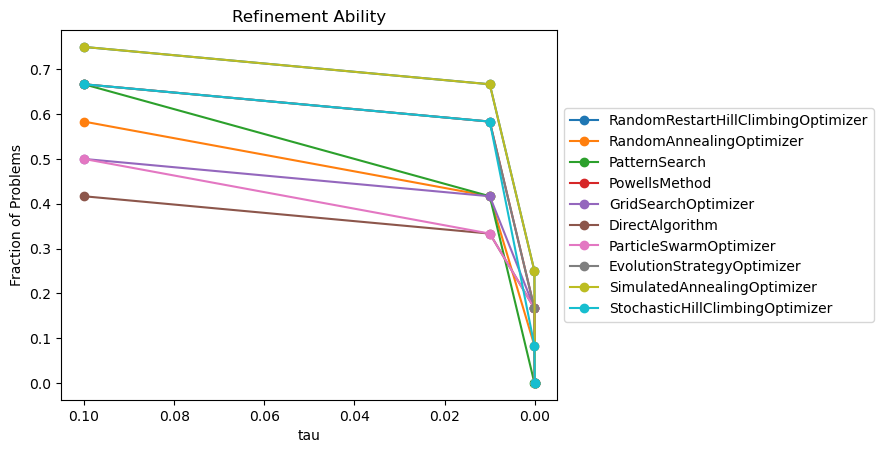

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for label, y in plot_dict.items():
    ax.plot(taus, y, 'o-', label=label)

ax.set_xlabel('tau')

plt.title(f"Refinement Ability")
ax.invert_xaxis()
ax.set_ylabel('Fraction of Problems')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()